NAIVE BAYES MODEL

In [2]:
import pandas as pd

# Load your datasets
approx_entropy_df = pd.read_csv('Combined_Entropy.csv')
entropy_per_channel_df = pd.read_csv('eeg_entropy_features.csv')
frequency_features_df = pd.read_csv('eeg_frequency_features.csv')

# Merge all datasets on Patient_ID
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID",how='left')
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID",how='left')

# Merge with suffixes to keep track of Label columns
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID", how='left', suffixes=('', '_entropy'))
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID", how='left', suffixes=('', '_frequency'))

# Check if 'Label_entropy' and 'Label_frequency' columns are identical to 'Label'
if 'Label_entropy' in combined_data.columns and (combined_data['Label'] == combined_data['Label_entropy']).all():
    combined_data = combined_data.drop(columns=['Label_entropy'])
if 'Label_frequency' in combined_data.columns and (combined_data['Label'] == combined_data['Label_frequency']).all():
    combined_data = combined_data.drop(columns=['Label_frequency'])

print(combined_data.head(1))
print(combined_data.shape)
print(combined_data['Label'].value_counts())



    Patient_ID  Label       Fp1       Fp2        F3        F4        C3  \
0  v1p_v1p.csv      1  1.642273  1.399319  1.788776  1.385568  1.894291   

         C4        P3        P4  ...  occipital_theta_avg_power  \
0  1.719796  1.915635  1.512754  ...                 556.439793   

   occipital_alpha_avg_power  occipital_beta_avg_power  \
0                 417.316758                589.752563   

   occipital_gamma_avg_power  temporal_delta_avg_power  \
0                 195.140531                  879.2552   

   temporal_theta_avg_power  temporal_alpha_avg_power  \
0                580.225853                478.095124   

   temporal_beta_avg_power  temporal_gamma_avg_power  \
0               480.728786                 232.60505   

   frontal_parietal_theta_ratio  
0                      0.983045  

[1 rows x 240 columns]
(121, 240)
Label
1    61
0    60
Name: count, dtype: int64


In [3]:
# Separate features and target label
X = combined_data.drop(columns=["Patient_ID", "Label"])
y = combined_data["Label"]

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

# Split data into training and testing sets (if not already split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (96, 238)
Shape of y_train: (96,)
Shape of X_test: (25, 238)
Shape of y_test: (25,)


Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.67      0.89      0.76         9

    accuracy                           0.80        25
   macro avg       0.79      0.82      0.79        25
weighted avg       0.83      0.80      0.80        25



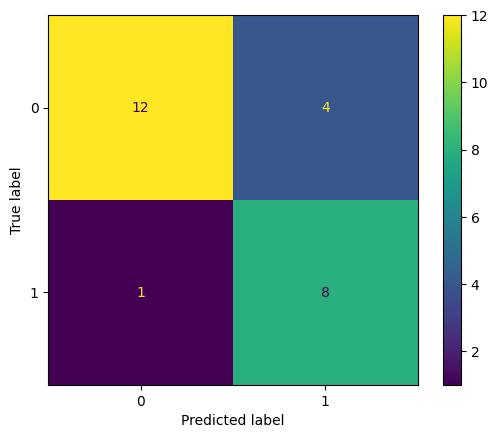

In [5]:
# Initialize and train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)

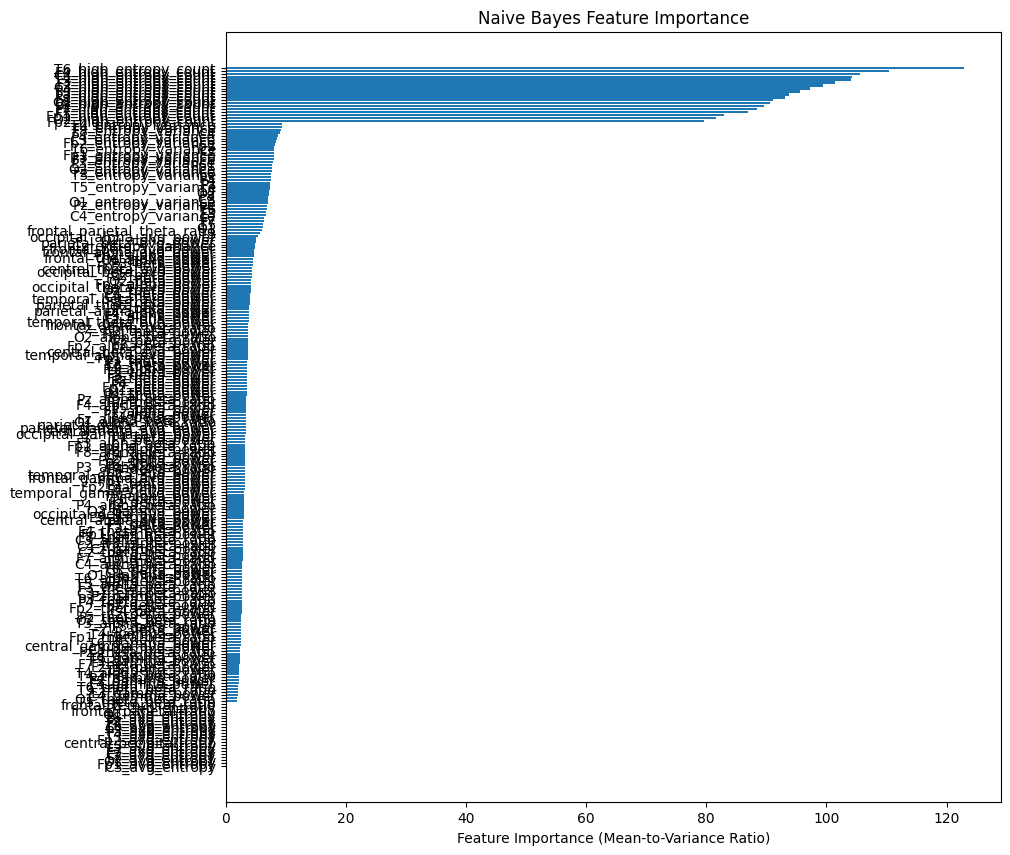

In [6]:
# Assuming you have already trained a GaussianNB model named nb_model
# and your features are stored in a DataFrame `X`

# Get the mean and variance learned for each feature
feature_means = nb_model.theta_
feature_variances = nb_model.var_  # Use 'var_' instead of 'sigma_'

# Calculate an importance score based on the ratio of mean to variance for each feature
importance_scores = np.abs(feature_means / np.sqrt(feature_variances)).mean(axis=0)

# Create a DataFrame to view feature importance in descending order
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance_scores})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Mean-to-Variance Ratio)")
plt.title("Naive Bayes Feature Importance")
plt.show()


In [7]:


def naive_bayes_hypertune(X_train, y_train, X_test, y_test):
    # Define the model
    nb_model = GaussianNB()

    # Define the hyperparameter grid
    param_grid = {
        "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Accuracy:", best_score)

    # Train the model with the best parameters
    nb_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
    nb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = nb_model.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)

    return nb_model  # Return the trained model



Best Parameters: {'var_smoothing': 1e-06}
Best Cross-Validation Accuracy: 0.781578947368421
Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.67      0.89      0.76         9

    accuracy                           0.80        25
   macro avg       0.79      0.82      0.79        25
weighted avg       0.83      0.80      0.80        25



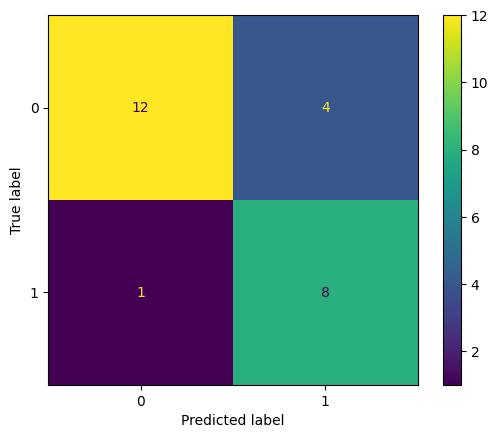

In [8]:
from sklearn.model_selection import GridSearchCV 

best_nb_model = naive_bayes_hypertune(X_train, y_train, X_test, y_test)

c:\Users\smrit\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 26it [00:17,  1.32s/it]                        



SHAP Summary Plot for Class 0 (Control)


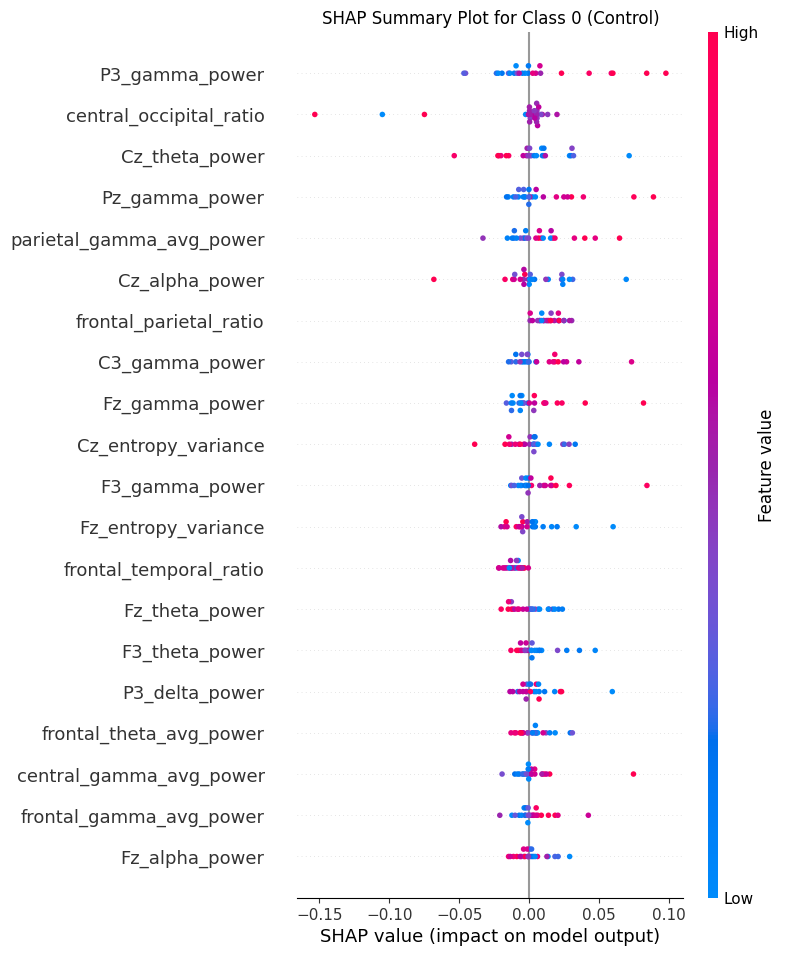


SHAP Summary Plot for Class 1 (ADHD)


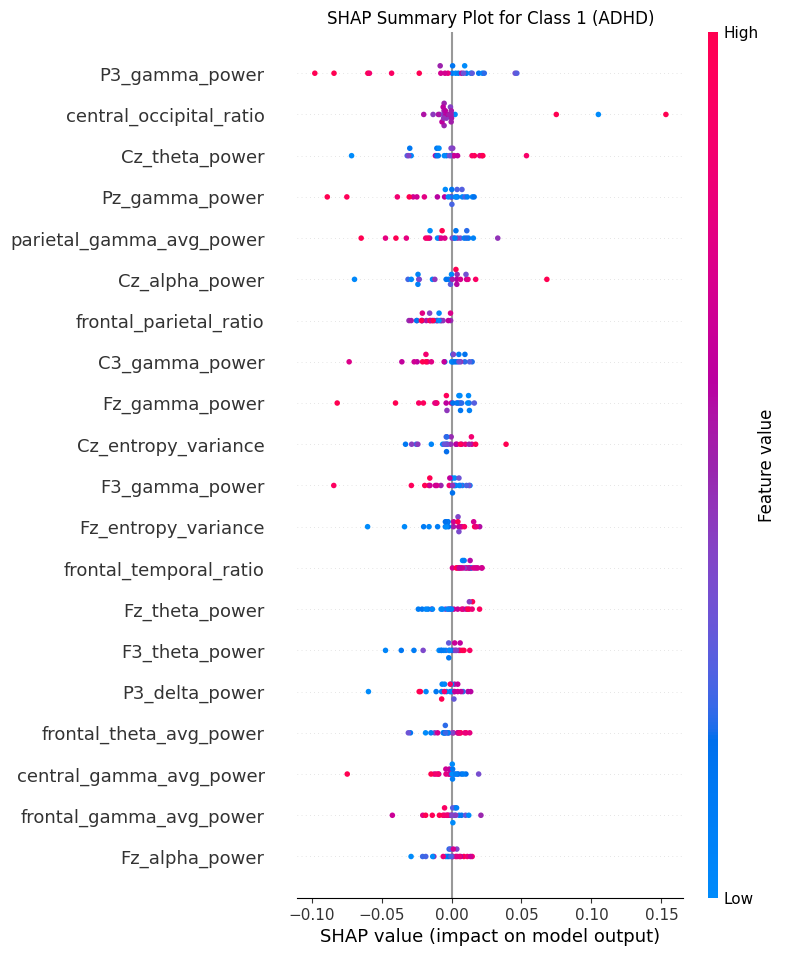

In [9]:
import shap
import matplotlib.pyplot as plt
feature_names = X_train.columns.tolist()  # Get feature names from the training set
target_names = ['Control', 'ADHD']  # Modify these names based on your dataset's labels

# Initialize SHAP explainer for a binary classification model
explainer = shap.Explainer(best_nb_model.predict_proba, X_train)
shap_values = explainer(X_test)

# Loop through both classes (binary classification)
for class_label in range(2):
    print(f"\nSHAP Summary Plot for Class {class_label} ({target_names[class_label]})")

    # Extract SHAP values for the specific class
    class_shap_values = shap_values.values[:, :, class_label]
    
    # Plot SHAP summary for this class
    shap.summary_plot(class_shap_values, X_test,
                      feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for Class {class_label} ({target_names[class_label]})")
    plt.show()


c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Explanation for Instance: 0
Predicted Class: 0
Probability of Predicted Class: 1.0
Local Feature Importance:
0.37 < frontal_parietal_ratio <= 1.29: -0.28121337496301557
P3_gamma_power > 201.73: -0.12189515086178265
0.38 < frontal_temporal_ratio <= 1.10: 0.116475113685985
parietal_gamma_avg_power > 175.85: -0.09992541852222794
Cz_beta_power <= 42.84: -0.07649282202294073
Fp1_gamma_power > 205.01: -0.07629542887244521
277.50 < T5_alpha_power <= 334.84: -0.06528198511991513
Cz_alpha_power <= 33.77: -0.06261337551419521
Fz_entropy_variance <= 2480.50: -0.05905681517419497
O1_gamma_power > 215.76: 0.05288087891714631


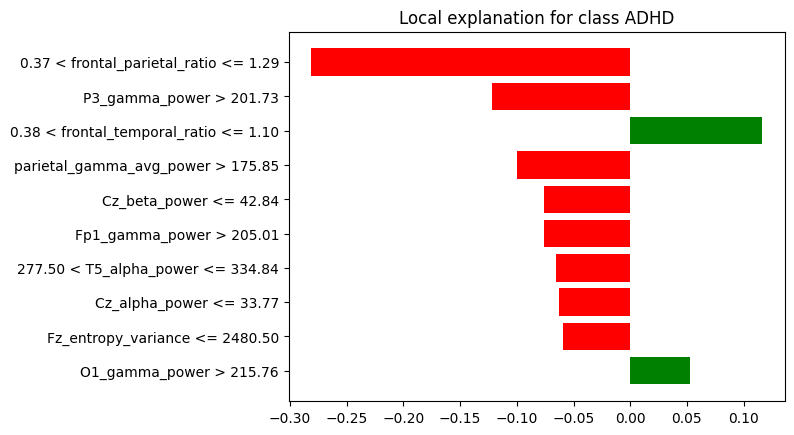

In [10]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Control', 'ADHD'],  # Adjust based on your label names
    mode='classification'
)
instance_index = 0
instance = X_test.iloc[instance_index]

# Choose a test instance to explain
exp = explainer.explain_instance(X_test.iloc[instance_index], best_nb_model.predict_proba, num_features=10)


exp.show_in_notebook(show_table=True)

print("Explanation for Instance:", instance_index)
print("Predicted Class:", best_nb_model.predict([instance])[0])
print("Probability of Predicted Class:", np.max(best_nb_model.predict_proba([instance])))
print("Local Feature Importance:")

for feature_name, weight in exp.as_list():
  print(f"{feature_name}: {weight}")
import matplotlib.pyplot as plt

# Customize the plot's background color
fig = exp.as_pyplot_figure()
fig.patch.set_facecolor('white')  # Change the background color to white

# Show the plot
plt.show()


